In [1]:
%matplotlib inline
from matplotlib import animation
from matplotlib.animation import PillowWriter
from matplotlib import cm
import matplotlib.pyplot as plt

plt.style.use('science')

# Burges' equation

$$ \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$$

The Fourier transform of the dynamical equation is 

$$\frac{\partial \hat{u}_{k}}{\partial t} = - \mathcal{FT}\{u\frac{\partial u}{\partial x} \} -\nu k^2 \hat{u}_{k} $$

cuja solução pode ser obtida numericamente usando um método de *operator splitting* tal que 
$$\hat{u}_{k}^{n+1/2}= \hat{u}_{k}^{n} - \Delta t \mathcal{FT}\{u\frac{\partial u}{\partial x} \}^n$$

$$\hat{u}_{k}^{n+1} = \hat{u}_{k}^{n+1/2} e^{-\Delta t \nu k^2}$$

com $t_n = n \Delta t$. 

In [2]:
import numpy as np
from scipy.fft import fft, ifft
# Size of the system
x = np.linspace(-np.pi,np.pi,2**12)
N = x.size
dx = x[1]-x[0]
# The time step definition
dt = 0.001
Nsteps = 1000
# Initial condition
n0 = np.zeros_like(x)
n0[:] = np.exp(-10*(x/2)**2)
# The vector of variables
n_hat = np.empty(N, dtype=np.complex64)
n = np.empty((Nsteps,N), dtype=np.float32)
n[0] = n0
# The Fourier variables and dealising vector
k = np.fft.fftfreq(N, d=dx)*2*np.pi
kmax_dealias = k.max()*2.0/3.0 # The Nyquist mode
dealias = np.array((np.abs(k) < kmax_dealias ),dtype =bool)
# The linear terms of PDE
def linear_terms_ft(k):
    nu = 0.001
    return -nu*k**2
# The non-linear terms of PDE (with dealising)
def nonlinear_terms_ft(n,k):
    return (-0.5j*k*fft(n**2))*dealias
# Defining the time derivative arrays
dndtlinear_hat = np.exp(dt*linear_terms_ft(k)) # can be calculated once
dndtnonlinear_hat = n_hat.copy()
# time evolution loop
n_hat[:] = fft(n[0]) # FT initial condition
for i in range(1,Nsteps):
    dndtnonlinear_hat[:] = nonlinear_terms_ft(n[i-1],k) # calculate the non-linear term
    n_hat[:] = (n_hat+dt*dndtnonlinear_hat)*dndtlinear_hat # updating in time
    n[i] = ifft(n_hat).real # IFT to next step

## Generate a plot

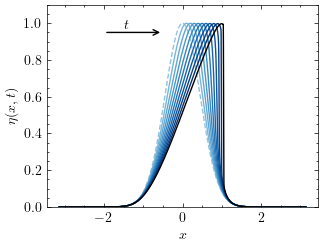

In [3]:
fig, ax = plt.subplots(1,1)

my_map = cm.get_cmap('Blues')
color = my_map(np.linspace(0.4,1.0,Nsteps//100))
plt.plot(x,n[0],'--',color=color[0])
for i in range(1,Nsteps//100):
    plt.plot(x,n[100*i],'-',color=color[i])
plt.plot(x,n[-1],'-k')
plt.xlabel('$x$')
plt.ylabel('$\eta(x,t)$')
plt.annotate("", xy=(-0.5, 0.95), xytext=(-2, 0.95),
            arrowprops=dict(arrowstyle="->"))
plt.text(-1.5,0.97,"$t$")
# plt.xlim(-1.0,1.0)
plt.ylim(0.,1.1)
fig.savefig('burgers.pdf')

## Generate a movie (MP4)

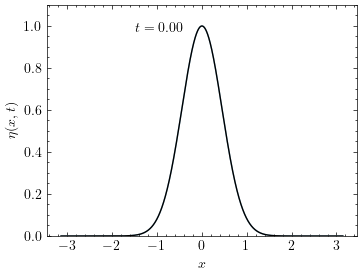

In [4]:
my_map = cm.get_cmap('Blues')
color = my_map(np.linspace(0.4,1.0,Nsteps//100))
def animate(i):
    ax.clear()
    for j in range(i//100+1):
        ax.plot(x,n[100*j],'-',color=color[j])
    ax.plot(x,n[i],'-k')
    ax.text(-1.5,0.97,'$t={:.2f}$'.format(i*dt))
    # ax.set_xlim(-1,1)
    ax.set_ylim(0.0,1.1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\eta(x,t)$')
    return fig,
    
fig, ax = plt.subplots(1,1,figsize=(4,3))
ani = animation.FuncAnimation(fig, animate, frames= Nsteps,
                               interval = 50)
writervideo = animation.FFMpegWriter(fps=100) 
ani.save('burgers.mp4',writer=writervideo,dpi=200)

## Generate a GIF

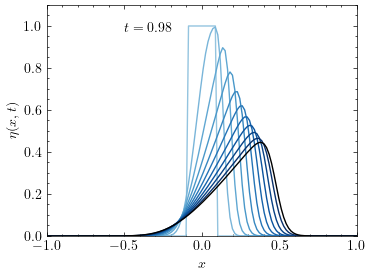

In [5]:
my_map = cm.get_cmap('Blues')
color = my_map(np.linspace(0.4,1.0,10))
def animate(i):
    ax.clear()
    for j in range(i//10+1):
        ax.plot(x,n[10*j],'-',color=color[j])
    ax.plot(x,n[i],'-k')
    ax.text(-0.5,0.97,'$t={:.2f}$'.format(i*dt))
    # ax.set_xlim(-1,1)
    ax.set_ylim(0.0,1.1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\eta(x,t)$')
    return fig,
    
fig, ax = plt.subplots(1,1,figsize=(4,3))
ani = animation.FuncAnimation(fig, animate, frames= 99,
                               interval = 50)
ani.save('burgers.gif',writer='pillow',fps=30,dpi=200)